In [34]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn
from pprint import pprint

# Background

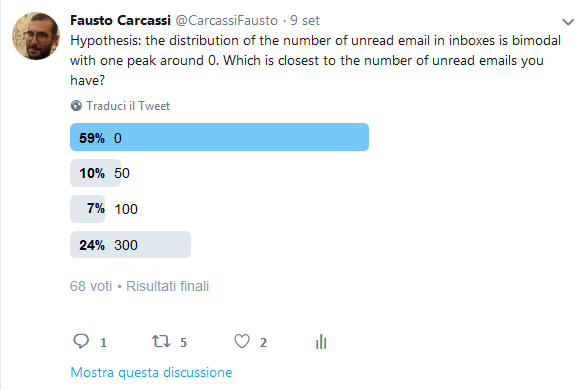

Data: twitter poll asking how many unread email one has.

- $H_0$: there is only one kind of person, the __reader__, who tends to read a lot of their emails.
- $H_1$: there are two kinds of persons, the __reader__ and the __nonreader__, one who tends to read a lot of their emails and one who tends to only read some of them.

The reader has a high probability of reading each email they get.
The nonreader has a low probability to read the emails they get.

For a certain number of received emails, the probability of a certain proportion of them being read is modelled by a binomial distribution. However, each person has a different number of emails, and the twitter poll does not tell us how many. We make the following assumptions:

- Everybody has enough emails to approximate infinity.
- Everybody leaves only a small proportion of them unread.

Given these assumptions, the binomial can be approximated by a Poisson distribution (see __[here](http://www.oxfordmathcenter.com/drupal7/node/297)__). The $\lambda$ parameter models the expected number of unread emails. So we don't need to know for each person how many emails they have overall.

Given the assumptions, the two hypotheses can be formulated as follows:

- $H_0$: the distribution of unread emails is best modelled by a Poisson distribution with some low $\lambda$ parameter.
- $H_1$: the distribution of unread emails is best modelled by a mixture of two Poisson parameters, one with a low $\lambda$ and one with a high $\lambda$.

How to find out which is best? Model comparison!

Here is how I will proceed:

1. Find the maximum likelihood estimation of the parameters given each hypothesis. I use simulated annealing to do this.
2. Do a log-likelihood test ratio test (I can do this because $H_0$ is nested within $H_1$)

# Proportions to counts

Pretty self explanatory:

In [3]:
proportions = [0.59, 0.10, 0.07, 0.24]

total = 68

counts = np.round([68 * prop for prop in proportions])

print(counts)

[ 40.   7.   5.  16.]


# Likelihood functions

I calculate the probability of obtaining the set of data given a single Poisson distribution.

The data does not tell us how many unread emails each person has precisely, but only whether they belong in a certain range.

The ranges are:
- 0-25
- 26-75
- 76-150
- $>$ 150

The data is a list of 5 numbers, i.e. the counts of responses (number of unread emails) in each range.

To find the loglikelihood of the whole dataset, I sum the loprobabilities of each number appearing in each range. The probability of a number of unread is just the sum of the probability mass of the Poisson distribution in that range. For $>$151 I use the survival function, defined as 1 minus the cumulative probability function up to 151.

In [4]:
# functions that tells you the probability of falling in an interval
def cum_func_log(min_count, max_count, lambda_par):
    return np.log(sp.stats.poisson.cdf(k=max_count, mu=lambda_par) - sp.stats.poisson.cdf(k=min_count-1, mu=lambda_par))

def loglikelihood_h0(data, lambda_par):
    # calculate the probability mass of being in each range
    # the probability of being in range n-m is equal to the cdf of being n minus the cdf of being up to n-1 
    # in the scipy implementation, mu is the lambda parameter and k is the number of observations
    
    # list containing the logprobabilities of the count of unread falling in each range
    logprob_ranges = [
        sp.stats.poisson.logcdf(k=25, mu=lambda_par),
        cum_func_log(26, 75, lambda_par),
        cum_func_log(76, 150, lambda_par),
        sp.stats.poisson.logsf(k=151, mu=lambda_par)
    ]

    # the loglikelihood of the whole dataset is simply the sum of the logprob of each datapoint given the parameter
    loglik = np.sum([
        n_in_range * logprob_range
        for n_in_range, logprob_range in zip(data, logprob_ranges)
    ])
    
    return loglik

Note that loglikelihood_h0 can returns -inf if the probability of the data is too small given the parameters.

Test the function to see that it works:

In [7]:
loglikelihood_h0([20, 10, 1, 3], 30)

-444.53215284602095

Function to calculate the likelihood of a the mixture with the chosen parameters given the data.

The function takes the lambda parameters of the two poisson and the weight of the first one.

In [8]:
# functions that tells you the probability of falling in an interval
def cum_func(min_count, max_count, lambda_par):
    return sp.stats.poisson.cdf(k=max_count, mu=lambda_par) - sp.stats.poisson.cdf(k=min_count-1, mu=lambda_par)

def loglikelihood_h1(data, params):
    # calculate the probability of the data given the mixture
    # the mixture probability of falling in an interval is equal to the weighted sum of the probabilities of each
    # component of the mixture.
    
    lambda_par_1, lambda_par_2, proportion_1 = params
    
    # calculate probabilities of being in each range in the two mixture components
    probs_first_ranges = [
        sp.stats.poisson.cdf(k=25, mu=lambda_par_1),
        cum_func(26, 75, lambda_par_1),
        cum_func(76, 150, lambda_par_1),
        sp.stats.poisson.sf(k=151, mu=lambda_par_1)
    ]
    
    probs_second_ranges = [
        sp.stats.poisson.cdf(k=25, mu=lambda_par_2),
        cum_func(26, 75, lambda_par_2),
        cum_func(76, 150, lambda_par_2),
        sp.stats.poisson.sf(k=151, mu=lambda_par_2)
    ]
    
    # calculate the probability of being in each range for the mixture distribution
    logprob_mixture_ranges = [
        np.log(prob_first_range * proportion_1 + prob_second_range * (1 - proportion_1))
        for prob_first_range, prob_second_range in zip(probs_first_ranges, probs_second_ranges)
    ]
    
    # calculate the likelihood of the parameters given the data, i.e. the p of the data given the parameters
    loglik = np.sum([
        n_in_range * logprob_mix_range
        for n_in_range, logprob_mix_range in zip(data, logprob_mixture_ranges)
    ])
    
    return loglik

Test to see that it works:

In [9]:
loglikelihood_h1([20, 10, 1, 3], [30, 20, 0.7])

-435.29117467251962

# Maximum likelihood estimation

I write a function to find the set of parameters that maximize the loglikelihood. Since logarithm is a monotonically increasing function, this is equivalent to maximizing the likelihood.

Simulated annealing is usually used to find the min of a function, therefore I miminize the negative loglikelihood.

In [55]:
def simulated_annealing(data, likelihood_func, initial_random_generator, update_function,
           n_steps=400, repetitions=50, cooling_factor=0.95):
    
    max_estimations = []
    
    # try to find the max likelihood parameter repetitions number of times
    for repetition in range(repetitions):   
        
        # start from a random point in the parameter space
        present_value = initial_random_generator()
        
        # attribute the temperature an initial value.
        # the greater the temperature, the higher the probability that the proposal will be accepted even if it is worse
        present_temperature = 1
        
        # finds the loglikelihood of the present value of the parameters
        negloglik_present = - likelihood_func(data, present_value)
        
        # repeat the search for n_steps
        for step in range(n_steps):
            
            # propose a value as a function of the present value
            proposed_value = update_function(present_value)
            
            # calculate the loglik of the proposed value
            negloglik_proposed = - likelihood_func(data, proposed_value)
            
            # calculate the difference between the new and the old loglikelihoods
            difference = negloglik_proposed - negloglik_present
            
            # calculate the acceptance probability as a function of the proposed and present logliks and the temperature
            acceptance_probability = 1 if difference < 0 else np.exp(-difference / present_temperature)
            
            # if the acceptance probability is greater than a random number in [0, 1], accept the proposed value
            if acceptance_probability > np.random.random():
                
                negloglik_present = negloglik_proposed
                present_value = proposed_value
                present_temperature *= cooling_factor
            
        max_estimations.append(present_value)
    return max_estimations
        

Test that the function works.

First define a bimodal distribution as a test:

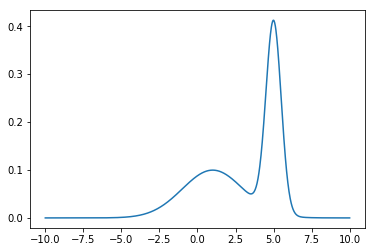

In [11]:
# create a bimodal distribution by mixing two normals
mixture_func = lambda data, x: sp.stats.norm.pdf(x, loc=1, scale=2) * 0.5 + sp.stats.norm.pdf(x, loc=5, scale=0.5) * 0.5

X = np.linspace(-10, 10, 1000)

# plot the bimodal distribution
plt.plot(X, [mixture_func([], x) for x in X])

Then test the function on that distribution

0


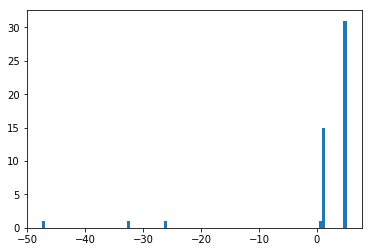

In [15]:
data = []
likelihood_func = mixture_func
initial_random_generator = sp.stats.norm.rvs
update_function = lambda present_position: sp.stats.norm.rvs(loc=present_position)

results = simulated_annealing(data, likelihood_func, initial_random_generator, update_function, 
                              n_steps=400, repetitions=50, cooling_factor=0.95)

plt.hist(results, bins=100)
plt.show()

As you can see, the correct global maximum is found a majority of time even with just 400 steps! And sometimes the function gets stuck on the local maximum. This is partially because the mean of the initial_random_generator function is closer to the local max than the global max. Overall, pretty good.

# Actual estimation

First get an idea of where the max is for H0, which is easy to visualize since it only has one parameter.

c:\users\pplsuser\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\pplsuser\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


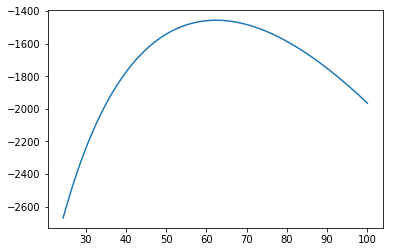

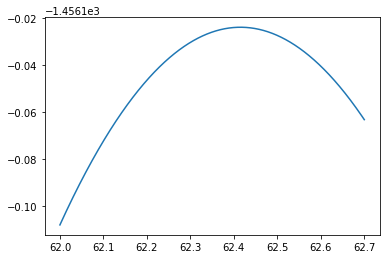

In [16]:
data = counts

X = np.linspace(0, 100, 10000)
plt.plot(X, [loglikelihood_h0(data, x) for x in X])
plt.show()

X = np.linspace(62, 62.7, 10000)
plt.plot(X, [loglikelihood_h0(data, x) for x in X])
plt.show()

Okay, the max is somewhere around 62.4. Let's see if the annealing finds it!

0


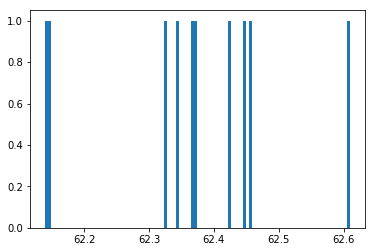

[62.371399167797762, 62.366064070673026, 62.343683044710765, 62.609423751669524, 62.147810940635466, 62.445241405912412, 62.425828675686816, 62.457807037049932, 62.14028829042423, 62.325130960427323]


In [17]:
likelihood_func = loglikelihood_h0
initial_random_generator = sp.stats.norm(loc=40, scale=1).rvs
update_function = lambda present_position: sp.stats.norm(loc=present_position, scale=4).rvs()

results_h0 = simulated_annealing(data, likelihood_func, initial_random_generator, update_function, 
                              n_steps=300, repetitions=10, cooling_factor=0.91)

plt.hist(results_h0, bins=100)
plt.show()

print(results_h0)

The estimation is pretty close to the actual max! Now onto the more complicated alternative hypothesis.

For the alternative hypothesis function, we need three parameters:
1. lambda_par_1: this is the $\lambda$ parameter of the first component of the mixture
2. lambda_par_2: this is the $\lambda$ parameter of the second component of the mixture
3. proportion_1: this is the weight of the first component

The $\lambda$ parameters are limited to the positive half of the real line, while the proportion parameter is bounded in the interval [0, 1]. The update function has to consider that so that it doesn't propose an impossible value.

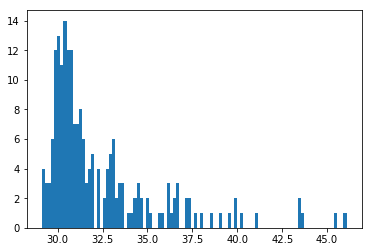

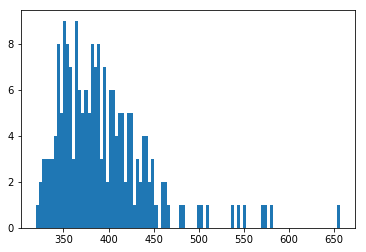

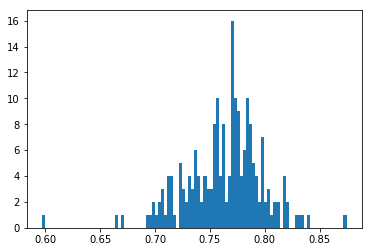

[5.0266789775082641, 5.0016778115866893, 0.97510576687392492, 4.986106625554358, 5.0093048765842161, 5.0173668399365807, 4.9802411714918771, 1.0307224292828281, 1.1642133928571461, 0.95117147007307357, 1.0380727075755829, 5.015665036374342, 0.86511878066879699, 4.9600766589760612, -26.117110244326877, 4.9761018361148857, 5.0713992174501312, 1.0495814972105586, 5.0956427550065539, 4.9772945476182198, 1.0009998607429513, 5.0100590897951882, 4.9517806126945736, 5.0187781171474324, 4.9466702634972171, 4.994398754933421, 1.0783321849744469, 1.010534317032701, 5.0230603839556283, 4.960122646946056, 0.9351190425788749, 1.0971474261909189, 5.0498017284109773, 4.9904791995028148, -32.413465662648207, 4.9562190278355303, 5.0345629762077468, 4.9811661363499162, 0.98407564014737336, 4.9175883391283701, 4.949979676260587, 4.9493175804840863, 4.9506290634964465, -47.4163143004928, 5.02181008523059, 5.0445929572201393, 0.95891690615662906, 4.988171714711771, 1.0505883360741319, 0.98457717181987769]


In [56]:
def update_function (present_position): 
    pres_lambda1, pres_lambda2, pres_prop = present_position
    return [
        sp.stats.lognorm(1, loc=pres_lambda1, scale=2).rvs(), # smaller scale so it stays close to 1
        sp.stats.lognorm(1, loc=pres_lambda2, scale=10).rvs(), # greater scale so it can move around more
        sp.stats.uniform.rvs()
    ]


def initial_random_generator():
    return [sp.stats.lognorm(1, loc=3).rvs(), sp.stats.lognorm(1, loc=300).rvs(), sp.stats.uniform.rvs()]


likelihood_func = loglikelihood_h1

results_h1 = simulated_annealing(data, likelihood_func, initial_random_generator, update_function, 
                              n_steps=500, repetitions=200, cooling_factor=0.85)


# get the estimated values for each parameter so I can plot them
# this looses the connection between the parameters but if there only one max and the estimations are close
# that should not be a problem
estim_lambda1, estim_lambda2, estim_prop = zip(*results_h1)

plt.hist(estim_lambda1, bins=100)
plt.show()

plt.hist(estim_lambda2, bins=100)
plt.show()

plt.hist(estim_prop, bins=100)
plt.show()

print(results)

It does look like the estimated values are clustering in a certain portion of the space. The highest found likelihood might be enough to show that the richer model can account significantly better for the data.

In [40]:
# find the best found parameters 
best_h1 = sorted(results_h1, key=lambda params: loglikelihood_h1(data, params))
best_h0 = sorted(results_h0, key=lambda params: loglikelihood_h0(data, params))

best_h1_params, best_h1_loglik =[[element, loglikelihood_h1(data, element)] for element in best_h1][-1]

best_h0_params, best_h0_loglik =[[element, loglikelihood_h0(data, element)] for element in best_h0][-1]

print("This is the best fit for the alternative hypothesis!")
print(best_h0_loglik)
print("This is the best fit for the null hypothesis!")
print(best_h1_loglik)
np.exp(-236.811)

This is the best fit for the alternative hypothesis!
-1456.12386136
This is the best fit for the null hypothesis!
-236.811463896


1.4265580407800844e-103

So the best combinations of parameters is [29.136463689089389, 466.15934902150389, 0.77239591660408258], which means that there is a group of people who in the long run tends to have on average 29 unread emails and another group that on average tends to have 466 unread emails. Moreover, there are more people in the second group than in the first. This set of parameters produces the observed data with a probability of 1.4265580407800844e-103. Which is absolutely tiny. Oh well.

Let's find the likelihood ratio!

In [54]:
logratio = -2 * (best_h0_loglik - best_h1_loglik)

sp.stats.chi2.sf(logratio, 2)

0.0

Pvalue is really tiny! So in conclusion, the model that assumes two types of people is better at accounting for the data than the model that only assumes one type of person.